In [1]:
from pathlib import Path
import os
from functools import partial

import pandas as pd

import torch
from torch import tensor,nn,optim
from torcheval.metrics import MulticlassAccuracy
import torchvision.transforms.functional as TF,torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.nn import init
from torch.optim import lr_scheduler

from miniai.datasets import *
from miniai.conv import *
from miniai.learner import *
from miniai.activations import *
from miniai.init import *
from miniai.sgd import *
from miniai.xtras import *

In [2]:
path = Path(os.path.expandvars('$SCRATCH/data/circadian'))

## Data

Looking at the data and making changes for the neural net.

In [3]:
meta_data = pd.read_csv(path/'meta_data.csv', low_memory=False)
meta_data[:3]

,cell_name,ZT
0,AAACAGCCAACCCTAA-6,ZT18
1,AAACCAACAGTAAAGC-6,ZT18
2,AAACCGAAGGTCCTAG-6,ZT18


In [4]:
meta_data.describe()

,cell_name,ZT
count,15992,15992
unique,15992,6
top,TTTGGTAAGGAAGTAT-7,ZT14
freq,1,3212


In [5]:
data = pd.read_csv(path/'RNA_count_mat.csv', low_memory=False)
data[:3]

,gene,AAACAGCCAACCCTAA-6,AAACCAACAGTAAAGC-6,AAACCGAAGGTCCTAG-6,AAAGCACCATTGTCCT-6,AAAGGACGTGAGGTGA-6,AAAGGAGCAAAGCGCA-6,AACAAAGGTAAAGCGG-6,AACAGATAGACTATTG-6,AACATAGCATGAGCAG-6,...,TTAGGATGTTTATCTG-7,TTATCCGTCACCTGCT-7,TTATTGCTCAAGTGTC-7,TTCCTTGAGTAAAGGT-7,TTCGTTAGTAACGAGG-7,TTGCCCGTCGCACAAT-7,TTGCGTCTCTTAGTCT-7,TTGGGTTAGCCACAAT-7,TTTAGCTTCAGGAAGC-7,TTTGGTAAGGAAGTAT-7
0,Meg3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Slc1a2,0,2,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Rian,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [6]:
data = data.set_index('gene').T
data[:3]

gene,Meg3,Slc1a2,Rian,Cyp2c40,Cyp2c69,Sgcz,Glul,Ugt2b37,Tmeff2,B830012L14Rik,...,Fam228a,Tmtc4,Mpp6,Ralgps1,Zfp580,Sept8,Cfap52,Arhgap27,F730043M19Rik,Bora
AAACAGCCAACCCTAA-6,0,0,0,0,0,0,0,0,0,0,...,0,0,6,3,0,0,0,0,0,0
AAACCAACAGTAAAGC-6,0,2,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1
AAACCGAAGGTCCTAG-6,0,0,0,0,0,0,0,0,0,0,...,1,0,4,1,0,0,0,0,0,0


I thought it would be better to join `meta_data` and `data` into a new data frame.

In [7]:
df = data.join(meta_data.set_index('cell_name'))
df

,Meg3,Slc1a2,Rian,Cyp2c40,Cyp2c69,Sgcz,Glul,Ugt2b37,Tmeff2,B830012L14Rik,...,Tmtc4,Mpp6,Ralgps1,Zfp580,Sept8,Cfap52,Arhgap27,F730043M19Rik,Bora,ZT
AAACAGCCAACCCTAA-6,0,0,0,0,0,0,0,0,0,0,...,0,6,3,0,0,0,0,0,0,ZT18
AAACCAACAGTAAAGC-6,0,2,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,1,ZT18
AAACCGAAGGTCCTAG-6,0,0,0,0,0,0,0,0,0,0,...,0,4,1,0,0,0,0,0,0,ZT18
AAAGCACCATTGTCCT-6,0,0,0,0,0,0,0,0,0,0,...,0,4,1,0,0,0,0,0,0,ZT18
AAAGGACGTGAGGTGA-6,0,0,0,0,0,0,0,0,0,0,...,0,0,2,0,0,0,0,0,0,ZT18
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTGCCCGTCGCACAAT-7,0,0,0,0,0,0,0,0,0,0,...,0,4,0,0,0,0,0,0,0,ZT06
TTGCGTCTCTTAGTCT-7,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,ZT06
TTGGGTTAGCCACAAT-7,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,ZT06
TTTAGCTTCAGGAAGC-7,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,ZT06


Here, I turn the time zone from string into integer categorical variables.

In [8]:
df['ZT'] = pd.Categorical(df['ZT'])
df['ZT'].cat.codes.values

array([4, 4, 4, ..., 1, 1, 1], dtype=int8)

In [9]:
df['code'] = df['ZT'].cat.codes
df.iloc[0]

Meg3                0
Slc1a2              0
Rian                0
Cyp2c40             0
Cyp2c69             0
                 ... 
Arhgap27            0
F730043M19Rik       0
Bora                0
ZT               ZT18
code                4
Name: AAACAGCCAACCCTAA-6, Length: 3002, dtype: object

## Using Pytorch

Now, we turn the pandas dataframe into pytorch tensors.

In [10]:
t_dep = tensor(df['code'], dtype=torch.long)
t_dep[:5]

/tmp/job.9212994/ipykernel_15865/2707305540.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  t_dep = tensor(df['code'], dtype=torch.long)


tensor([4, 4, 4, 4, 4])

In [11]:
indep_cols = list(df.columns)[:-2]
t_indep = tensor(df[indep_cols].values, dtype=torch.float32)
t_indep

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 2., 0.,  ..., 0., 0., 1.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

In [12]:
t_indep.shape

torch.Size([15992, 3000])

We use `RandomSplitter` to split the data into training and validating sets.

In [13]:
def RandomSplitter(valid_pct=0.2, seed=None):
    "Create function that splits `items` between train/val with `valid_pct` randomly."
    def _inner(o):
        if seed is not None: torch.manual_seed(seed)
        rand_idx = list(torch.randperm(len(o)).numpy())
        cut = int(valid_pct * len(o))
        return rand_idx[cut:],rand_idx[:cut]
    return _inner

In [14]:
trn_split,val_split=RandomSplitter(seed=42)(df)

In [15]:
trn_indep,val_indep = t_indep[trn_split],t_indep[val_split]
trn_dep,val_dep = t_dep[trn_split],t_dep[val_split]
len(trn_indep),len(val_indep)

(12794, 3198)

In [16]:
trn_indep.shape, trn_dep.shape

(torch.Size([12794, 3000]), torch.Size([12794]))

### DataLoaders

We create dataloaders with minibatches using batch size of 64.

In [17]:
set_seed(42)
trn_dl = DataLoader(list(zip(trn_indep, trn_dep)), batch_size=64, shuffle=True)
val_dl = DataLoader(list(zip(val_indep, val_dep)), batch_size=64, shuffle=True)
dls = DataLoaders(trn_dl, val_dl)
dt = dls.train
xb,yb = next(iter(dt))
xb.shape,yb[:10]

(torch.Size([64, 3000]), tensor([1, 3, 4, 3, 4, 3, 2, 1, 1, 0]))

- We create `metrics` using `MulticlassAccuracy` from `torcheval` library.
- `ActivationStats` allows us to look into the model and see how the model is doing.
- `cbs` are callbacks.
  - `DeviceCB` is used for moving data from GPU to CPU and back.
  - `ProgressCB` tracks loss and accuracy after each batch and shows the progress of the epoch each epoch.

In [18]:
metrics = MetricsCB(accuracy=MulticlassAccuracy(device='cpu'))
astats = ActivationStats(nn.ReLU)
cbs = [DeviceCB(), metrics, ProgressCB(plot=False), astats]

We create a model with three layers. Because the output of the last layer is 6, we do not have to use softmax.

In [19]:
set_seed(42)
model = nn.Sequential(*[
    nn.Linear(3000, 100), 
    nn.ReLU(), 
    nn.Linear(100, 100),
    nn.ReLU(),
    nn.Linear(100, 6),
])

We find a good learning rate by plotting the loss using different learning rates. Anywhere between 1e-2 and 1e-3 should be good.

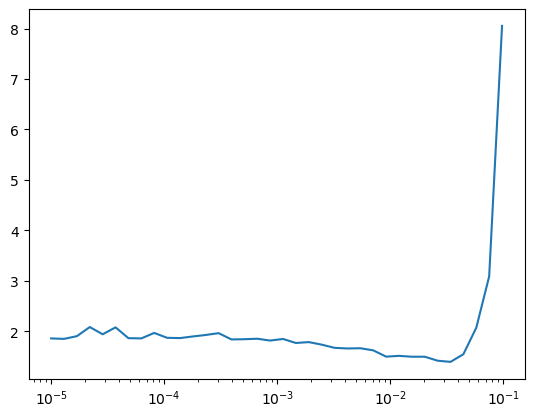

In [20]:
TrainLearner(model, dls, loss_func=F.cross_entropy, cbs=cbs).lr_find()

In [21]:
learn = TrainLearner(model, dls, lr=1e-3, loss_func=F.cross_entropy, cbs=cbs)
learn.fit(5)

accuracy,loss,epoch,train,time
0.616,1.198,0,True,00:00
0.795,0.820,0,False,00:00
0.883,0.651,1,True,00:00
0.926,0.500,1,False,00:00
0.947,0.412,2,True,00:00
0.960,0.343,2,False,00:00
0.963,0.296,3,True,00:00
0.972,0.259,3,False,00:00
0.974,0.230,4,True,00:00
0.976,0.209,4,False,00:00


## Normalizaing data

Normalizing data may allow the model train better.

In [22]:
t_indep /= t_indep.max(dim=0)[0]

In [23]:
t_indep

tensor([[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0105, 0.0000,  ..., 0.0000, 0.0000, 0.1667],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]])

In [24]:
set_seed(42)
trn_dl = DataLoader(list(zip(trn_indep, trn_dep)), batch_size=64, shuffle=True)
val_dl = DataLoader(list(zip(val_indep, val_dep)), batch_size=64, shuffle=True)
dls = DataLoaders(trn_dl, val_dl)

In [25]:
model = nn.Sequential(*[
    nn.Linear(3000, 100), 
    nn.ReLU(), 
    nn.Linear(100, 100),
    nn.ReLU(), 
    nn.Linear(100, 6),
])

In [26]:
learn = TrainLearner(model, dls, lr=1e-3, loss_func=F.cross_entropy, cbs=cbs)
learn.fit(5)

accuracy,loss,epoch,train,time
0.670,1.148,0,True,00:00
0.882,0.738,0,False,00:00
0.937,0.567,1,True,00:00
0.956,0.436,1,False,00:00
0.969,0.360,2,True,00:00
0.976,0.302,2,False,00:00
0.978,0.260,3,True,00:00
0.981,0.229,3,False,00:00
0.983,0.203,4,True,00:00
0.984,0.185,4,False,00:00


Normalizing the data doesn't change anything for the neural net. How about normalizing the parameters?

In [27]:
def init_params(m, leaky=0.):
    if isinstance(m, (nn.Linear, nn.Conv2d)): init.kaiming_normal_(m.weight, a=leaky)

In [28]:
set_seed(42)
model = nn.Sequential(*[
    nn.Linear(3000, 100), 
    nn.ReLU(), 
    nn.Linear(100, 100),
    nn.ReLU(), 
    nn.Linear(100, 6),
])
model.apply(init_params);

In [29]:
learn = TrainLearner(model, dls, lr=1e-3, loss_func=F.cross_entropy, cbs=cbs)
learn.fit(5)

accuracy,loss,epoch,train,time
0.801,0.613,0,True,00:00
0.932,0.243,0,False,00:00
0.945,0.199,1,True,00:00
0.962,0.154,1,False,00:00
0.966,0.133,2,True,00:00
0.969,0.119,2,False,00:00
0.974,0.103,3,True,00:00
0.976,0.099,3,False,00:00
0.981,0.084,4,True,00:00
0.978,0.085,4,False,00:00


## Optimizer

Instead of using vanilla stochastic gradient descent, we can try `optim.AdamW`. This is Adam optimizer with weight decay combined.

In [30]:
set_seed(42)
model = nn.Sequential(*[
    nn.Linear(3000, 100), 
    nn.ReLU(), 
    nn.Linear(100, 100),
    nn.ReLU(), 
    nn.Linear(100, 6),
])
model.apply(init_params);

In [31]:
learn = TrainLearner(model, dls, lr=1e-3, loss_func=F.cross_entropy, cbs=cbs, opt_func=optim.AdamW)
learn.fit(5)

accuracy,loss,epoch,train,time
0.954,0.174,0,True,00:00
0.993,0.032,0,False,00:00
0.997,0.012,1,True,00:00
0.996,0.014,1,False,00:00
1.000,0.003,2,True,00:01
0.997,0.010,2,False,00:00
1.000,0.002,3,True,00:01
0.997,0.008,3,False,00:00
1.000,0.001,4,True,00:01
0.997,0.008,4,False,00:00


## Learning rate scheduler

Instead of using a constant learning rate, we can change it. We start out small. Then, we increase and decrease to the starting learning rate. 

In [35]:
def _lr(cb): return cb.pg['lr']
def _beta1(cb): return cb.pg['betas'][0]
class RecorderCB(Callback):
    def __init__(self, **d): self.d = d
    def before_fit(self, learn):
        self.recs = {k:[] for k in self.d}
        self.pg = learn.opt.param_groups[0]
    
    def after_batch(self, learn):
        if not learn.training: return
        for k,v in self.d.items():
            self.recs[k].append(v(self))

    def plot(self):
        for k,v in self.recs.items():
            plt.plot(v, label=k)
            plt.legend()
            plt.show()
rec = RecorderCB(lr=_lr, mom=_beta1)

In [36]:
set_seed(42)
model = nn.Sequential(*[
    nn.Linear(3000, 100), 
    nn.ReLU(), 
    nn.Linear(100, 100),
    nn.ReLU(), 
    nn.Linear(100, 6),
])
lr, epochs = 1e-3, 5
tmax = epochs * len(dls.train)
sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
xtra = [BatchSchedCB(sched), rec]
learn = TrainLearner(model, dls, F.cross_entropy, lr=lr, cbs=cbs+xtra, opt_func=optim.AdamW)
learn.fit(epochs)

accuracy,loss,epoch,train,time
0.806,0.649,0,True,00:00
0.997,0.035,0,False,00:00
0.991,0.047,1,True,00:01
0.997,0.013,1,False,00:00
0.999,0.006,2,True,00:00
0.997,0.009,2,False,00:00
1.000,0.002,3,True,00:01
0.997,0.007,3,False,00:00
1.000,0.002,4,True,00:01
0.998,0.007,4,False,00:00


This is a plot for values of learning rate and momentum. 

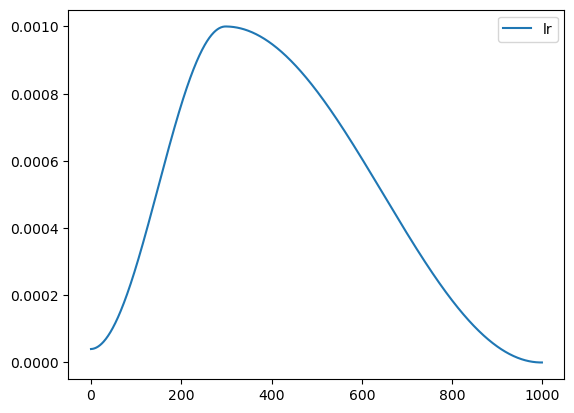

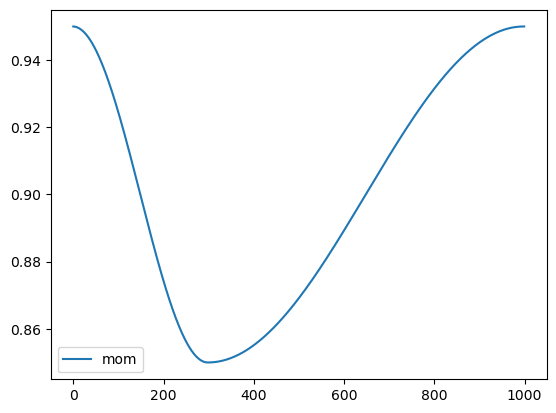

In [37]:
rec.plot()